## Initial analysis and data prep

This notebook is intended to investigate some of the data features of our dataset and do the needed data processing for getting the data ready for the deeplearning models

In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

In [446]:
path_local_file= './greenmobility-demand-prediction/2020FullDataset.csv'
df = pd.read_csv(path_local_file)

In [447]:
df.columns

Index(['date', 'customerIDHash', 'reservationIDHash', 'startLat', 'startLon',
       'startRentalCallSuccessful', 'startRentalCallSuccessfulTime',
       'startStreet', 'startCity', 'endLat', 'endLon', 'endTime',
       'endRentalCallSuccessful', 'endRentalCallSuccessfulTime', 'endStreet',
       'endCity', 'endLatUser', 'endLonUser', 'trip', 'distanceKM',
       'tripDuration', 'preReservationDuration'],
      dtype='object')

This dataset is a limited version of what data is actually avalible. The customerID and reservationID hashes is to obscure the actual number

The data consists of two elements: **trips** and **bookings**. This is identified by the calculated column trip, which just identifies if the entry has a value in "endRentalCallSuccesfullTime".
A trip is when a customer has unlocked the car
A booking is when a customer has reserved the car, but never started the trip meaning the cars wasn't unlocked 

The greenmobility zone is divided into multiple different subzones an one major operational zones.

// Show image

We are only interested in elements within the major zone so firstly we will filter the data to get rid of reservation not in the zone

In [4]:
# Getting the coordinates of the Copenhagen zone
with open('./greenmobility-demand-prediction/CPH.json') as json_file:
    data = json.load(json_file)
    cph_main=json.loads(data['polygons'])[0]
    json_file.close()

In [5]:
# Convert data to polygon
from shapely.geometry import Point, Polygon
coords=[]
for x in cph_main['coordinates']:
    coords.append((x['lon'],x['lat']))
poly = Polygon(coords)

### "Data cleaning"

In [448]:
df_trip=df[df['trip']==1]

In [449]:
df_trip=df_trip[[poly.contains(Point(x)) for x in list(zip(df_trip['startLon'], df_trip['startLat']))]]
df_trip.reset_index(inplace=True,drop=True)
#df_trip=df_trip[[poly.contains(Point(x)) for x in list(zip(df_trip['endLon'], df_trip['endLat']))]]
len(df_trip)

426729

In [458]:
df_trip.startRentalCallSuccessfulTime = pd.to_datetime(df_trip.startRentalCallSuccessfulTime)
df_trip.date = pd.to_datetime(df_trip.date)

### Visualize the demand

In [450]:
#!pip install folium
import folium
from folium import plugins
from folium import *
import matplotlib.pyplot as plt
import seaborn as sns

In [515]:
regionmap = folium.Map(location = [55.7, 12.55], tiles = "CartoDB positron", zoom_start=11)
aline=folium.PolyLine(locations=list(zip(y,x)),weight=4,color = 'green')
regionmap.add_child(aline)

regionmap

In [451]:
time_label = ["0"+str(i)+":00" if i <10 else str(i)+":00" for i in range(0,24)]

In [466]:
#map_GreenMob = folium.Map(location = [55.7, 12.55], tiles = "CartoDB positron", zoom_start=12)
map_GreenMob = folium.Map(location = [55.7, 12.55], tiles = "OpenStreetMap", zoom_start=12)
time_column=plot_df_time.startRentalCallSuccessfulTime

GM_data = [[[row['startLat'],row['startLon']] for _, row in
            plot_df_time[time_column.dt.hour == i].iterrows()] for i in range(0,24)]

HM = plugins.HeatMapWithTime(GM_data,index = time_label,
                             radius=10,
                             auto_play=True,
                             max_opacity=0.8,)
HM.add_to(map_GreenMob)
map_GreenMob
#Mere lir version kunne være:
#https://nbviewer.jupyter.org/github/python-visualization/folium/blob/master/examples/TimeSliderChoropleth.ipynb

In [467]:
plot_df = df_trip[(df_trip.startRentalCallSuccessfulTime.dt.date == pd.to_datetime('2020-10-13'))  &
       (df_trip.startRentalCallSuccessfulTime.dt.hour == 13)]

# Only for small data set.
map_CPH = folium.Map(location = [55.7, 12.55], tiles = "CartoDB positron", zoom_start=11)
coords = list(zip(plot_df['startLat'],df_trip['startLon']))
for c in coords:
    folium.Circle(c, radius=2, color='red').add_to(map_CPH)

#Define Grid
vertical_lines = 13
horizontal_lines = 13

#x_coords = np.linspace(smallgrid_x.min(),smallgrid_x.max(),vertical_lines)
#y_coords = np.linspace(smallgrid_y.min(),smallgrid_y.max(),horizontal_lines)
x_coords = np.linspace(df_trip.startLon.min(),df_trip.startLon.max(),vertical_lines)
y_coords = np.linspace(df_trip.startLat.min(),df_trip.startLat.max(),horizontal_lines)

for ele in y_coords:
    line_location =[(ele,x_coords[0]),(ele,x_coords[-1])]
    aline=folium.PolyLine(locations=line_location,weight=2,color = 'blue')
    map_CPH.add_child(aline)
    
for ele in x_coords:
    line_location =[(y_coords[0],ele),(y_coords[-1],ele)]
    aline=folium.PolyLine(locations=line_location,weight=2,color = 'blue')
    map_CPH.add_child(aline)

map_CPH

In [120]:
# Construct weeekday and weekend dataframes
df_weekday = df_trip[(df_trip.startRentalCallSuccessfulTime.dt.weekday!=5)
        & (df_trip.startRentalCallSuccessfulTime.dt.weekday!=6)]
df_weekday.reset_index(inplace=True,drop=True)

df_weekend = df_trip[(df_trip.startRentalCallSuccessfulTime.dt.weekday==5)
        | (df_trip.startRentalCallSuccessfulTime.dt.weekday==6)]
df_weekend.reset_index(inplace=True,drop=True)

In [528]:
sns.set(rc={'axes.facecolor':'f2f2f2', 'figure.facecolor':'white'})

In [129]:
# Weekday
ts_data = []
for hour_idx in range(24):
    ts_list=[]
    for date_idx in np.unique(df_weekday.startRentalCallSuccessfulTime.dt.date):
        ts_list.append(sum((df_weekday.startRentalCallSuccessfulTime.dt.hour == hour_idx) &
                      (df_weekday.startRentalCallSuccessfulTime.dt.date == date_idx)))
    ts_data.append(ts_list)

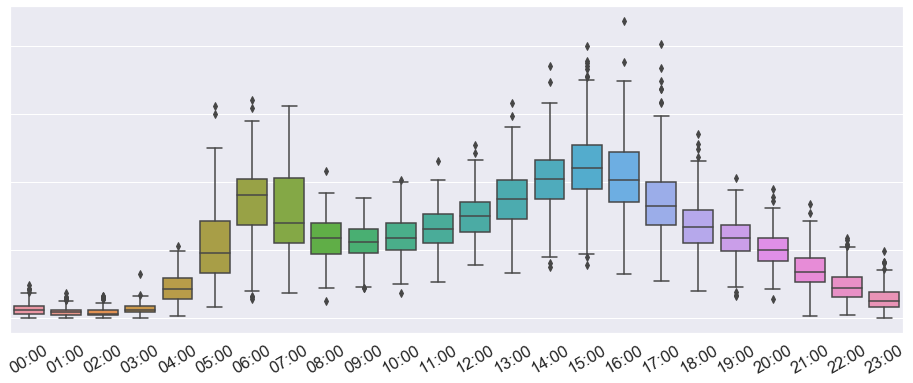

In [491]:
sns.set(rc={'figure.figsize':(16,6)})
sns.set(font_scale = 1.5)
ts_wd_df = pd.DataFrame(np.array(ts_data).T, columns=time_label)
ax = sns.boxplot(x="variable",y="value",data=pd.melt(ts_wd_df.drop([0,209,235])))
ax.set(xlabel='',ylabel='',title='') 
ax.set_xticklabels(time_label,rotation=30)
ax.set_yticklabels('')
plt.savefig('Weekday_boxplot.jpg')
print()

In [237]:
# Weekend
ts_data_weekend = []
for hour_idx in range(24):
    ts_list=[]
    for date_idx in np.unique(df_weekend.startRentalCallSuccessfulTime.dt.date):
        ts_list.append(sum((df_weekend.startRentalCallSuccessfulTime.dt.hour == hour_idx) &
                      (df_weekend.startRentalCallSuccessfulTime.dt.date == date_idx)))
    ts_data_weekend.append(ts_list)

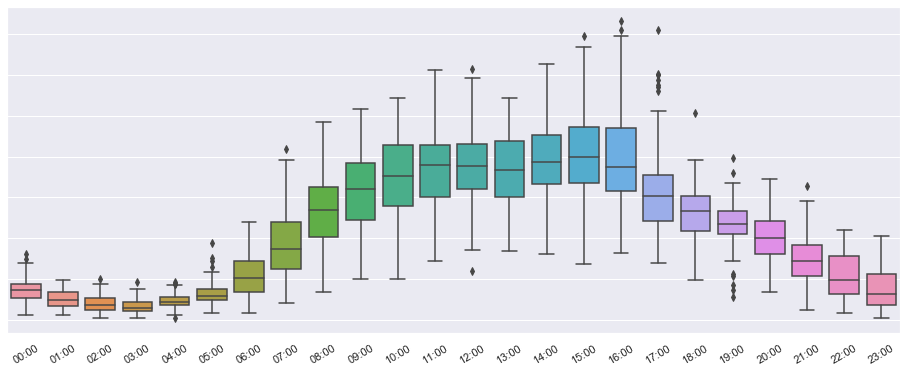

In [490]:
ts_we_df = pd.DataFrame(np.array(ts_data_weekend).T, columns=time_label)
ax = sns.boxplot(x="variable",y="value",data=pd.melt(ts_we_df))
ax.set(xlabel='',ylabel='',title='')
ax.set_xticklabels(time_label,rotation=30)
ax.set_yticklabels('')
plt.savefig('Weekend_boxplot.jpg')
print()

In [ ]:
df_timearray = df_trip.startRentalCallSuccessfulTime

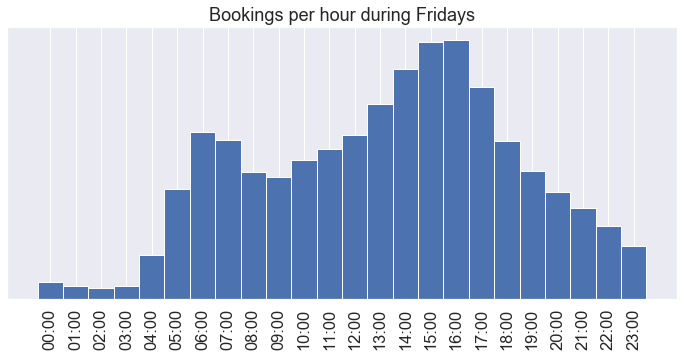

In [524]:
# Friday
plt.figure(figsize=(12,5))
plt.hist(pd.to_datetime(df_trip[
    (df_timearray.dt.weekday==4)
    ].startRentalCallSuccessfulTime).dt.hour,
        bins=np.arange(0,25))
plt.xticks(np.arange(0,24)+0.5,time_label,rotation=90)
title = 'Bookings per hour during Fridays'
plt.yticks([])
plt.title(title)
#plt.savefig(title + '.pdf')
print()

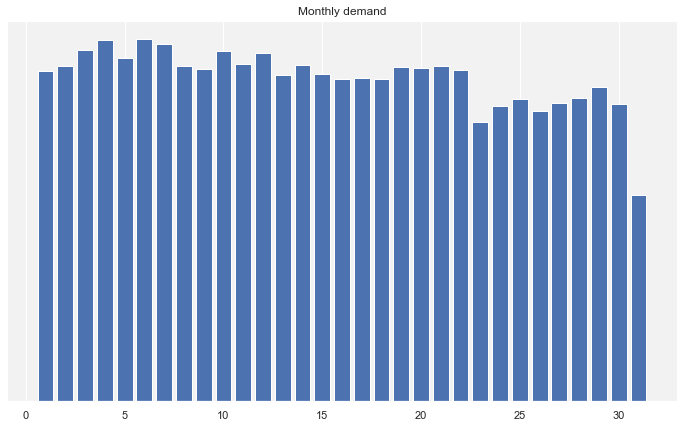

In [527]:
plt.figure(figsize=(12,7))
month_array = df_timearray[~df_timearray.dt.day.isna()].dt.day.values
(month_days, counts) = np.unique(month_array, return_counts=True)
plt.bar(month_days,counts)
plt.yticks([])
title = 'Monthly demand'
plt.title(title)
#plt.savefig(title + '.pdf')
print()

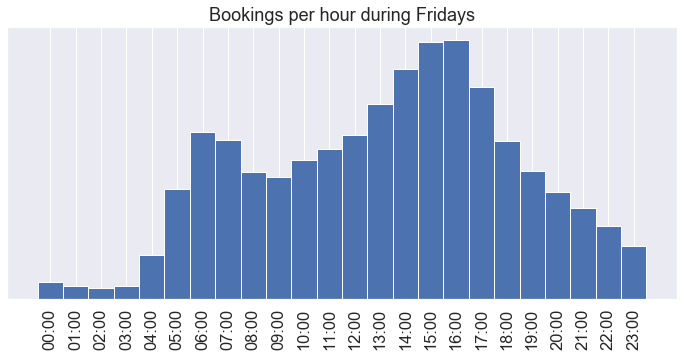

In [521]:
# Friday
plt.figure(figsize=(12,5))
plt.hist(pd.to_datetime(df_trip[
    (df_timearray.dt.weekday==4)
    ].startRentalCallSuccessfulTime).dt.hour,
        bins=np.arange(0,25))
plt.xticks(np.arange(0,24)+0.5,time_label,rotation=90)
title = 'Bookings per hour during Fridays'
plt.yticks([])
plt.title(title)
#plt.savefig(title + '.pdf')
print()

In [514]:
daily_activity = []
day_of_year = df_trip.date.dt.dayofyear
doy_data = np.array(day_of_year)
for day in np.unique(doy_data):
    daily_activity.append(sum(doy_data == day))

([], <a list of 0 Text yticklabel objects>)

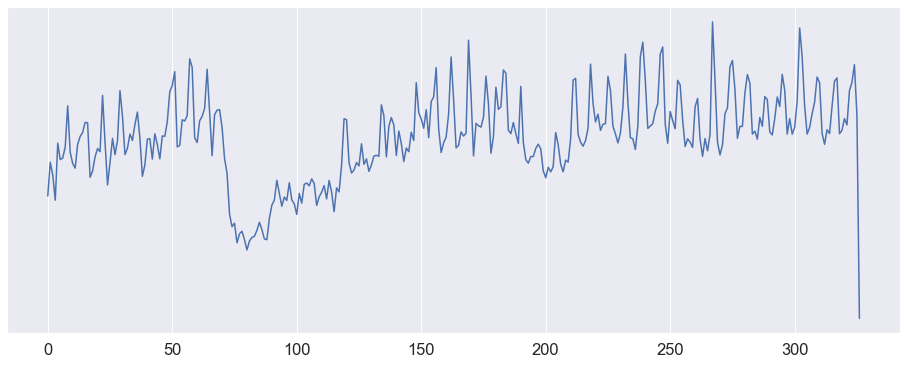

In [516]:
plt.plot(daily_activity)
plt.yticks([])

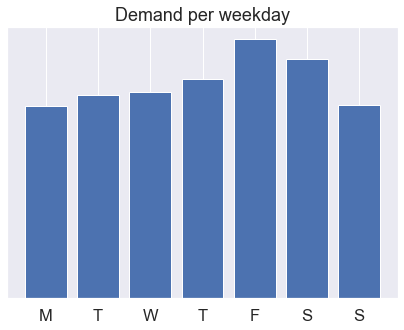

In [522]:
plt.figure(figsize=(7,5))
day_array = df_timearray[~df_timearray.dt.weekday.isna()].dt.weekday.values
(days, counts) = np.unique(day_array, return_counts=True)
plt.bar(days,counts)
#plt.ylim(40000,60000)
plt.xticks(days,('M','T','W','T','F','S','S'))
plt.yticks([])
title = 'Demand per weekday'
plt.title(title)
#plt.savefig(title + '.pdf')
print()

### Prediction visualisation

In [529]:
#Define Grid
vertical_lines = 13
horizontal_lines = 13
x_coords = np.linspace(df_trip.startLon.min(),df_trip.startLon.max(),vertical_lines)
y_coords = np.linspace(df_trip.startLat.min(),df_trip.startLat.max(),horizontal_lines)

In [530]:
# make geo data
geos = []
areas = []
c = 0
for i in range(vertical_lines-1):
    for j in range(horizontal_lines-1):
        c += 1
        polygon_squares = {'type': 'Polygon',
                           'coordinates': [[[x_coords[i], y_coords[j]],
                                            [x_coords[i+1], y_coords[j]],
                                            [x_coords[i+1], y_coords[j+1]],
                                            [x_coords[i], y_coords[j+1]],
                                            [x_coords[i], y_coords[j]]]]}
        #props = {'area': 'a{}'.format(c)}
        areas.append('a{}'.format(c))
        geos.append({'type': 'Feature', 
                     'geometry': polygon_squares, 
                     'properties': {'area': 'a{}'.format(c)}})

geodata = {'type': 'FeatureCollection', 'features': geos}

# test-data with random variable
predictions = pd.DataFrame(areas,columns=['area'])
predictions['variable'] = np.random.random(len(predictions.area))

In [531]:
# base map
prediction_map = folium.Map(location=[55.7, 12.55], tiles='cartodbpositron', zoom_start=11)

# tile layers
#folium.TileLayer('cartodbpositron', overlay=False, show=True, name="light").add_to(prediction_map)
#folium.TileLayer('cartodbdark_matter', overlay=False, show=False, name="dark").add_to(prediction_map)
#folium.TileLayer('openstreetmap', overlay=False, show=False, name="color").add_to(prediction_map)

choropleth = folium.Choropleth(
    geo_data=geodata,
    name='choropleth',
    data=predictions,
    columns=['area', 'variable'],
    key_on='feature.properties.area',
    legend_name = 'Traffic prediction',
    fill_color='YlGn', #Colormap
    fill_opacity=0.3,
    line_opacity=0.1,
    highlight = lambda x: {'weight': 3, 'color': '#000000','fillColor': '#000000', 'fillOpacity': 1}
).add_to(prediction_map)

# tooltip
tooltip_text = []
for idx in range(len(data)):
    tooltip_text.append(str(round(predictions['variable'][idx], 2)))
    geodata['features'][idx]['properties']['tooltip'] = tooltip_text[idx]
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['tooltip'], labels=False))

# random day of points
df_plot = df_trip[pd.to_datetime(df_trip.date) == pd.Timestamp('2020-11-22 00:00:00')]

#Cluster of points.
fg=folium.FeatureGroup(name='My Points', show=True)
prediction_map.add_child(fg)
marker_cluster = folium.plugins.MarkerCluster().add_to(fg)
                                 
# layer control
folium.LayerControl('topleft', collapsed=True).add_to(prediction_map)
    
coords_list = list(zip(df_plot['startLat'],df_plot['startLon']))
for c in coords_list:
    folium.Circle(c, radius=1, color='red').add_to(fg)
    
prediction_map

In [532]:
smallgrid_x = np.array([12.51763 , 12.59104667])
smallgrid_y = np.array([55.6661065 , 55.71602183])
#Define Grid
small_vertical_lines = 5
small_horizontal_lines = 5

x_coords = np.linspace(smallgrid_x.min(),smallgrid_x.max(),small_vertical_lines)
y_coords = np.linspace(smallgrid_y.min(),smallgrid_y.max(),small_horizontal_lines)

In [534]:
'''
df_smallgrid = df_trip[
    (df_trip.startLat > smallgrid_y[0]) &
    (df_trip.startLat < smallgrid_y[1]) &
    (df_trip.startLon > smallgrid_x[0]) &
    (df_trip.startLon < smallgrid_x[1])
]
df_smallgrid.reset_index(inplace=True,drop=True)
'''

In [535]:
# make geo data
geos = []
areas = []
c = 0
for i in range(small_vertical_lines-1):
    for j in range(small_horizontal_lines-1):
        c += 1
        polygon_squares = {'type': 'Polygon',
                           'coordinates': [[[x_coords[i], y_coords[j]],
                                            [x_coords[i+1], y_coords[j]],
                                            [x_coords[i+1], y_coords[j+1]],
                                            [x_coords[i], y_coords[j+1]],
                                            [x_coords[i], y_coords[j]]]]}
        #props = {'area': 'a{}'.format(c)}
        areas.append('a{}'.format(c))
        geos.append({'type': 'Feature', 
                     'geometry': polygon_squares, 
                     'properties': {'area': 'a{}'.format(c)}})

geodata = {'type': 'FeatureCollection', 'features': geos}

# test-data with random variable
predictions = pd.DataFrame(areas,columns=['area'])
predictions['variable'] = np.random.random(len(predictions.area))

In [536]:
# base map
mini_map = folium.Map(location=[55.7, 12.55], tiles='cartodbpositron', zoom_start=11)

# tile layers
#folium.TileLayer('cartodbpositron', overlay=False, show=True, name="light").add_to(prediction_map)
#folium.TileLayer('cartodbdark_matter', overlay=False, show=False, name="dark").add_to(prediction_map)
#folium.TileLayer('openstreetmap', overlay=False, show=False, name="color").add_to(prediction_map)

choropleth = folium.Choropleth(
    geo_data=geodata,
    name='choropleth',
    data=predictions,
    columns=['area', 'variable'],
    key_on='feature.properties.area',
    legend_name = 'Traffic prediction',
    fill_color='YlGn', #Colormap
    fill_opacity=0.3,
    line_opacity=0.1,
    highlight = lambda x: {'weight': 3, 'color': '#000000','fillColor': '#000000', 'fillOpacity': 1}
).add_to(mini_map)

# tooltip
tooltip_text = []
for idx in range(len(data)):
    tooltip_text.append(str(round(predictions['variable'][idx], 2)))
    geodata['features'][idx]['properties']['tooltip'] = tooltip_text[idx]
choropleth.geojson.add_child(folium.features.GeoJsonTooltip(['tooltip'], labels=False))

# random day of points
#df_plot = df_smallgrid[pd.to_datetime(df_trip.date) == pd.Timestamp('2020-11-22 00:00:00')]

#Cluster of points.
#fg=folium.FeatureGroup(name='My Points', show=True)
#mini_map.add_child(fg)
#marker_cluster = folium.plugins.MarkerCluster().add_to(fg)
                                 
# layer control
folium.LayerControl('topleft', collapsed=True).add_to(mini_map)
    
coords_list = list(zip(df_plot['startLat'],df_plot['startLon']))
for c in coords_list:
    folium.Circle(c, radius=1, color='red').add_to(fg)
    
mini_map